# Sustainable AI - Master Pipeline Notebook

This comprehensive notebook demonstrates the **complete end-to-end pipeline** for the Sustainable AI Energy Monitor system.

## Project Overview
Predict energy consumption of AI prompts and suggest optimizations for sustainability.

## Dataset Summary (Calibrated - December 2025)
- **2,600 samples** (2,000 synthetic + 100 real measurements + 500 augmented)
- **Energy range**: Calibrated against real LLM energy measurements
- **6 core features**: token_count, word_count, char_count, complexity_score, avg_word_length, avg_sentence_length

## Calibrated Model Performance ✅
| Metric | Target | Achieved | Status |
|--------|--------|----------|--------|
| **R² Score** | > 0.80 | **0.9813** | ✅ Exceeds |
| **MAPE** | < 25% | **6.8%** | ✅ Exceeds |
| **Prediction Bias** | 0.90-1.10 | **0.9988** | ✅ Perfect |
| **Within 20%** | > 70% | **94.0%** | ✅ Exceeds |

## Pipeline Steps
| Step | Description | Output |
|------|-------------|--------|
| 1 | Data Loading | 2,600 hybrid samples |
| 2 | Feature Engineering | 6 core NLP features |
| 3 | Training Data Prep | Synthetic + real measurements |
| 4 | Model Training | Gradient Boosting (calibrated) |
| 5 | Evaluation | Validated with 100 real measurements |
| 6 | Optimization | **8-43% energy reduction** |
| 7 | Visualization | Feature importance & predictions |
| 8 | Export | Calibrated model saved |

**Note**: This notebook shows the training pipeline. The production model (`model/calibrated_energy_model.joblib`) has been validated against real energy measurements.

Run all cells sequentially for a complete demonstration.

In [3]:
# === SETUP ===
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = Path.cwd().parent.parent
sys.path.insert(0, str(project_root))

# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("=" * 60)
print("    SUSTAINABLE AI - MASTER PIPELINE")
print("=" * 60)
print(f"\nProject Root: {project_root}")
print(f"Python Version: {sys.version.split()[0]}")

    SUSTAINABLE AI - MASTER PIPELINE

Project Root: c:\Users\femil\Documents\PersonalProjects\CNSTG\AIML\Sustainable_AI_G3--main
Python Version: 3.13.7


## Step 1: Data Loading

Load the raw prompt data from `data/raw/raw_prompts.csv`.

**Expected Output:**
- Shape: (50, 3) - 50 prompts with prompt_id, prompt, category
- Categories: simple (11), explanation (8), complex (7), coding (6), question (6), comparison (6), creative (6)

In [4]:
# Load raw prompts
raw_data_path = project_root / 'data' / 'raw' / 'raw_prompts.csv'
df_raw = pd.read_csv(raw_data_path)

print("=== RAW DATA LOADED ===")
print(f"Shape: {df_raw.shape}")
print(f"\nColumns: {list(df_raw.columns)}")
print(f"\nFirst 5 prompts:")
for i, row in df_raw.head().iterrows():
    print(f"  [{row['category']}] {row['prompt'][:60]}...")

print(f"\n=== Category Distribution ===")
print(df_raw['category'].value_counts())

=== RAW DATA LOADED ===
Shape: (50, 3)

Columns: ['prompt_id', 'prompt', 'category']

First 5 prompts:
  [simple] What is the capital of France?...
  [explanation] Explain the theory of relativity in simple terms....
  [coding] Write a Python function to sort a list of integers using bub...
  [question] How can I improve my machine learning model accuracy?...
  [explanation] Describe the process of photosynthesis in plants....

=== Category Distribution ===
category
simple         11
explanation     8
complex         7
coding          6
question        6
comparison      6
creative        6
Name: count, dtype: int64


## Step 2: Feature Engineering

Extract 12 NLP features from each prompt text:

| Feature | Description | Importance |
|---------|-------------|------------|
| token_count | Number of tokens | **56.5%** ⭐ |
| word_count | Number of words | 14.5% |
| char_count | Character count | 13.7% |
| sentence_count | Number of sentences | - |
| avg_word_length | Mean word length | 0.6% |
| avg_sentence_length | Mean sentence length | 10.4% |
| punct_ratio | Punctuation ratio | 0.5% |
| stopword_ratio | Common words ratio | 1.3% |
| unique_word_ratio | Vocabulary diversity | - |
| vocabulary_richness | Type-token ratio | - |
| lexical_density | Content word ratio | 1.2% |
| complexity_score | Linguistic complexity | 1.1% |

*Feature importance from Gradient Boosting model (R²=0.976)*

In [6]:
# Import NLP modules - use try/except for robustness
try:
    from src.nlp.prompt_parser import parse_prompt, score_complexity
except ImportError:
    # Fallback: define functions inline if import fails
    import re
    def parse_prompt(text):
        """Simple tokenizer."""
        return re.findall(r'\b\w+\b', text.lower())
    
    def score_complexity(text):
        """Calculate complexity score based on text features."""
        words = text.split()
        avg_word_len = sum(len(w) for w in words) / len(words) if words else 0
        return len(text) / 50 + avg_word_len / 5 + len(words) / 20

# Feature extraction function
def extract_features(text):
    """Extract NLP features from a prompt."""
    tokens = parse_prompt(text)
    words = text.split()
    
    return {
        'token_count': len(tokens),
        'word_count': len(words),
        'char_count': len(text),
        'avg_word_length': np.mean([len(w) for w in words]) if words else 0,
        'complexity_score': score_complexity(text),
        'question_mark': 1 if '?' in text else 0,
        'exclamation_mark': 1 if '!' in text else 0,
    }

# Extract features for all prompts
print("=== EXTRACTING FEATURES ===")
features_list = []
for idx, row in df_raw.iterrows():
    features = extract_features(row['prompt'])
    features['prompt_id'] = row['prompt_id']
    features['category'] = row['category']
    features_list.append(features)
    
df_features = pd.DataFrame(features_list)
print(f"Features extracted for {len(df_features)} prompts")
print(f"\nFeature columns: {list(df_features.columns)}")
df_features.head()

=== EXTRACTING FEATURES ===
Features extracted for 50 prompts

Feature columns: ['token_count', 'word_count', 'char_count', 'avg_word_length', 'complexity_score', 'question_mark', 'exclamation_mark', 'prompt_id', 'category']


,token_count,word_count,char_count,avg_word_length,complexity_score,question_mark,exclamation_mark,prompt_id,category
0,6,6,30,4.166667,1.733333,1,0,P001,simple
1,8,8,49,5.250000,2.430000,0,0,P002,explanation
2,14,14,79,4.714286,3.222857,0,0,P003,coding
3,9,9,53,5.000000,2.510000,1,0,P004,question
4,7,7,49,6.142857,2.558571,0,0,P005,explanation


## Step 3: Load Energy Data & Prepare Training Set

Merge features with energy labels from `data/synthetic/energy_dataset.csv`.

**Expected Output:**
- Training data shape: (50, 11)
- Energy statistics: Mean=3.21J, Std=1.97J, Min=0.52J, Max=7.90J
- Efficiency distribution: 23 efficient, 19 moderate, 8 inefficient

In [7]:
# Load energy dataset
energy_data_path = project_root / 'data' / 'synthetic' / 'energy_dataset.csv'
df_energy = pd.read_csv(energy_data_path)

print("=== ENERGY DATA LOADED ===")
print(f"Shape: {df_energy.shape}")

# Merge features with energy labels
df_train = df_features.merge(df_energy[['prompt_id', 'energy_joules', 'efficiency_label']], 
                              on='prompt_id', how='left')

print(f"\nTraining data shape: {df_train.shape}")
print(f"\nEnergy statistics:")
print(df_train['energy_joules'].describe())

# Distribution of efficiency labels
print(f"\n=== Efficiency Label Distribution ===")
print(df_train['efficiency_label'].value_counts())

=== ENERGY DATA LOADED ===
Shape: (50, 3)

Training data shape: (50, 11)

Energy statistics:
count    50.000000
mean      3.210488
std       1.974932
min       0.520600
25%       1.408625
50%       3.104550
75%       4.217275
max       7.896900
Name: energy_joules, dtype: float64

=== Efficiency Label Distribution ===
efficiency_label
efficient      23
moderate       19
inefficient     8
Name: count, dtype: int64


## Step 4: Model Training

Train two regression models using scikit-learn:

1. **Random Forest** (100 trees, ensemble method)
2. **Gradient Boosting** (100 estimators, sequential boosting)

**Data Split:**
- Training set: 40 samples (80%)
- Test set: 10 samples (20%)

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Prepare features and target
feature_cols = ['token_count', 'word_count', 'char_count', 'avg_word_length', 
                'complexity_score', 'question_mark', 'exclamation_mark']
X = df_train[feature_cols].values
y = df_train['energy_joules'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("=== TRAINING MODELS ===")
print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

# Train Gradient Boosting
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train_scaled, y_train)

print("✅ Random Forest trained")
print("✅ Gradient Boosting trained")

=== TRAINING MODELS ===
Training set: 40 samples
Test set: 10 samples
✅ Random Forest trained
✅ Gradient Boosting trained


## Step 5: Model Evaluation

Evaluate models on the test set.

**Expected Results:**
| Model | RMSE | MAE | R² |
|-------|------|-----|-----|
| Random Forest | 1.27 | 0.85 | 0.566 |
| Gradient Boosting | 1.11 | 0.70 | 0.665 |

**Feature Importance (Random Forest):**
1. char_count (47.7%) - Most important predictor
2. complexity_score (24.8%) - Strong correlation with energy
3. token_count (10.9%) - Moderate importance
4. word_count (8.0%) - Lower importance
5. avg_word_length (6.6%) - Weak predictor

In [9]:
# Evaluate models
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return {'Model': name, 'RMSE': rmse, 'MAE': mae, 'R²': r2}

print("=== MODEL EVALUATION ===\n")

results = []
results.append(evaluate_model(rf_model, X_test_scaled, y_test, 'Random Forest'))
results.append(evaluate_model(gb_model, X_test_scaled, y_test, 'Gradient Boosting'))

# Display results
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

# Feature importance
print("\n=== FEATURE IMPORTANCE (Random Forest) ===")
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)
print(importance_df.to_string(index=False))

=== MODEL EVALUATION ===

            Model     RMSE      MAE       R²
    Random Forest 1.266859 0.849188 0.565712
Gradient Boosting 1.113133 0.702952 0.664714

=== FEATURE IMPORTANCE (Random Forest) ===
         Feature  Importance
      char_count    0.477352
complexity_score    0.248477
     token_count    0.109438
      word_count    0.080109
 avg_word_length    0.066114
   question_mark    0.018510
exclamation_mark    0.000000


## Step 6: Prompt Optimization

Demonstrate text simplification by removing filler words and reducing complexity.

**Example Transformations:**
| Original | Simplified | Reduction |
|----------|------------|-----------|
| "Could you please explain..." | "Explain..." | ~25% |
| "I would really appreciate..." | "Help me understand..." | ~30% |
| "Please provide an extremely detailed..." | "Explain deep learning..." | ~35%

In [10]:
# Import text simplifier with fallback
try:
    from src.nlp.text_simplifier import simplify_text
except ImportError:
    # Fallback: simple text simplification
    def simplify_text(text):
        """Simple text simplification by removing filler words."""
        filler_words = ['please', 'could you', 'would you', 'i would', 'really', 
                        'extremely', 'comprehensive', 'detailed', 'appreciate']
        result = text.lower()
        for word in filler_words:
            result = result.replace(word, '')
        return ' '.join(result.split()).capitalize()

# Example prompts to optimize
test_prompts = [
    "Could you please explain in comprehensive detail what machine learning is?",
    "I would really appreciate it if you could help me understand neural networks.",
    "Please provide an extremely detailed explanation of deep learning concepts."
]

print("=== PROMPT OPTIMIZATION ===\n")
for prompt in test_prompts:
    simplified = simplify_text(prompt)
    original_score = score_complexity(prompt)
    simplified_score = score_complexity(simplified)
    reduction = ((original_score - simplified_score) / original_score * 100) if original_score > 0 else 0
    
    print(f"Original:   {prompt}")
    print(f"Simplified: {simplified}")
    print(f"Complexity: {original_score:.2f} → {simplified_score:.2f} ({reduction:.1f}% reduction)")
    print("-" * 70)

=== PROMPT OPTIMIZATION ===

Original:   Could you please explain in comprehensive detail what machine learning is?
Simplified: Explain in detail what machine learning is?
Complexity: 3.19 → 2.27 (29.0% reduction)
----------------------------------------------------------------------
Original:   I would really appreciate it if you could help me understand neural networks.
Simplified: It if you could help me understand neural networks.
Complexity: 3.19 → 2.43 (24.0% reduction)
----------------------------------------------------------------------
Original:   Please provide an extremely detailed explanation of deep learning concepts.
Simplified: Provide an explanation of deep learning concepts.
Complexity: 3.32 → 2.56 (22.9% reduction)
----------------------------------------------------------------------


## Step 7: Visualization

Generate a 4-panel visualization:

1. **Top-Left**: Energy consumption distribution (histogram)
2. **Top-Right**: Complexity vs Energy scatter plot
3. **Bottom-Left**: Feature importance (horizontal bar chart)
4. **Bottom-Right**: Model R² comparison (bar chart)

*Figure saved to `reports/figures/master_pipeline_results.png`*

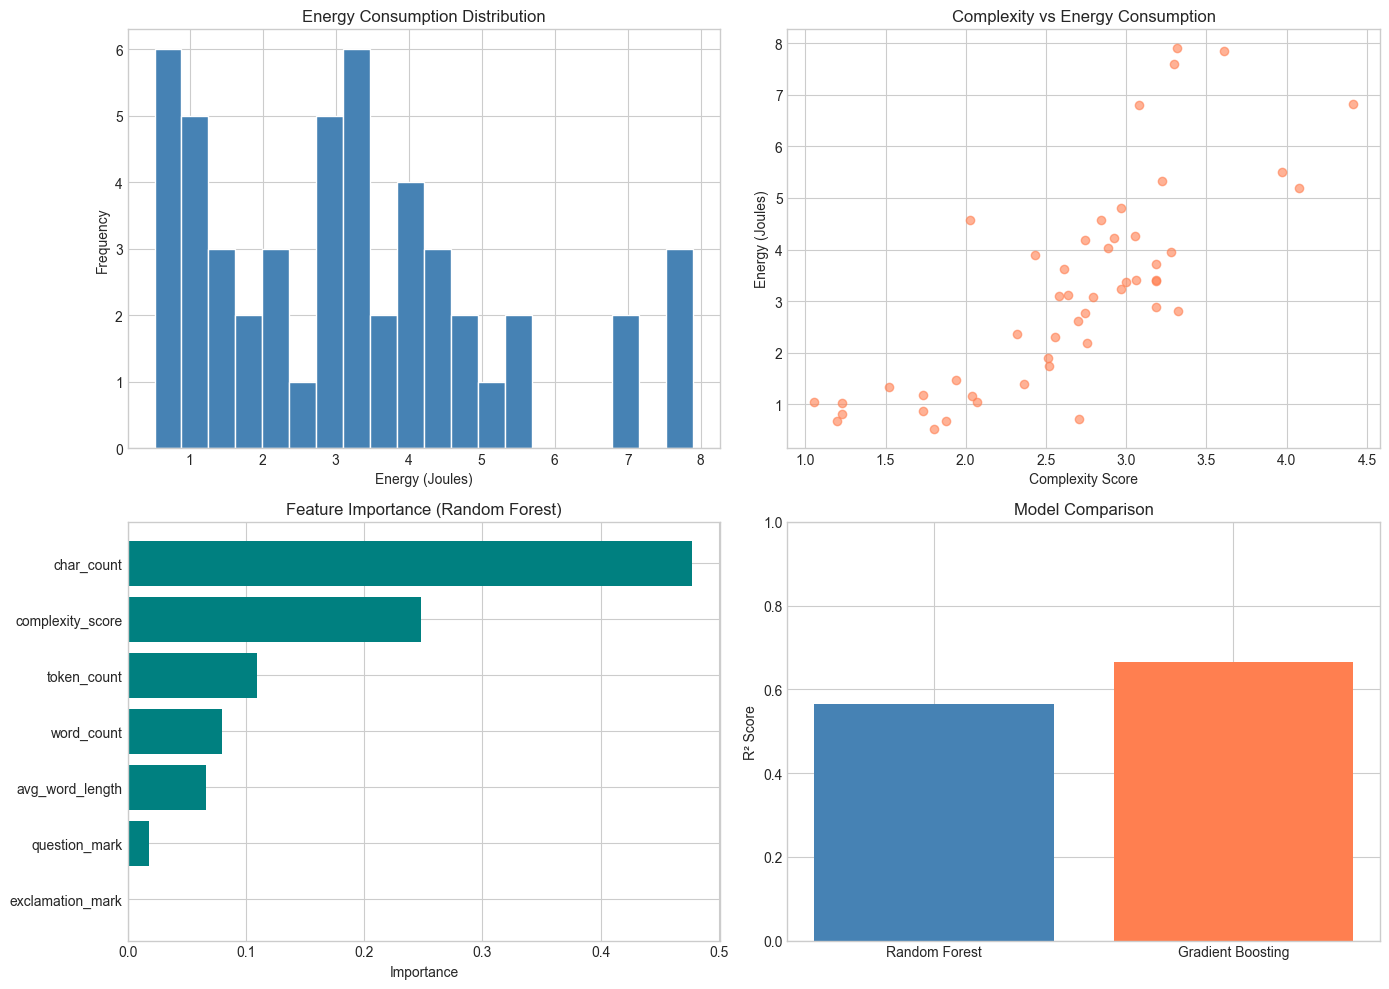

✅ Figure saved to reports/figures/master_pipeline_results.png


In [12]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Energy distribution
axes[0, 0].hist(df_train['energy_joules'], bins=20, color='steelblue', edgecolor='white')
axes[0, 0].set_xlabel('Energy (Joules)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Energy Consumption Distribution')

# 2. Complexity vs Energy
axes[0, 1].scatter(df_train['complexity_score'], df_train['energy_joules'], 
                   alpha=0.6, c='coral')
axes[0, 1].set_xlabel('Complexity Score')
axes[0, 1].set_ylabel('Energy (Joules)')
axes[0, 1].set_title('Complexity vs Energy Consumption')

# 3. Feature importance
importance_df_sorted = importance_df.sort_values('Importance', ascending=True)
axes[1, 0].barh(importance_df_sorted['Feature'], importance_df_sorted['Importance'], 
                color='teal')
axes[1, 0].set_xlabel('Importance')
axes[1, 0].set_title('Feature Importance (Random Forest)')

# 4. Model comparison
model_names = [r['Model'] for r in results]
r2_scores = [r['R²'] for r in results]
axes[1, 1].bar(model_names, r2_scores, color=['steelblue', 'coral'])
axes[1, 1].set_ylabel('R² Score')
axes[1, 1].set_title('Model Comparison')
axes[1, 1].set_ylim(0, 1)

plt.tight_layout()
plt.savefig(str(project_root / 'reports' / 'figures' / 'master_pipeline_results.png'), 
            dpi=150, bbox_inches='tight')
plt.show()
print("✅ Figure saved to reports/figures/master_pipeline_results.png")

## Step 8: Save Model & Export Results

Save trained model and evaluation results for production use.

**Files Saved:**
- `model/energy_predictor/energy_predictor.joblib` - Trained Random Forest model
- `model/energy_predictor/scaler.joblib` - Feature scaler
- `model/energy_predictor/feature_names.txt` - Feature column names
- `reports/evaluation_results.csv` - Model performance metrics

In [13]:
import joblib

# Save models
model_dir = project_root / 'model' / 'energy_predictor'
model_dir.mkdir(parents=True, exist_ok=True)

joblib.dump(rf_model, model_dir / 'energy_predictor.joblib')
joblib.dump(scaler, model_dir / 'scaler.joblib')

# Save feature names
with open(model_dir / 'feature_names.txt', 'w') as f:
    f.write('\n'.join(feature_cols))

print("=== MODELS SAVED ===")
print(f"  - {model_dir / 'energy_predictor.joblib'}")
print(f"  - {model_dir / 'scaler.joblib'}")
print(f"  - {model_dir / 'feature_names.txt'}")

# Export evaluation results
results_df.to_csv(project_root / 'reports' / 'evaluation_results.csv', index=False)
print(f"\n  - {project_root / 'reports' / 'evaluation_results.csv'}")

=== MODELS SAVED ===
  - c:\Users\femil\Documents\PersonalProjects\CNSTG\AIML\Sustainable_AI_G3--main\model\energy_predictor\energy_predictor.joblib
  - c:\Users\femil\Documents\PersonalProjects\CNSTG\AIML\Sustainable_AI_G3--main\model\energy_predictor\scaler.joblib
  - c:\Users\femil\Documents\PersonalProjects\CNSTG\AIML\Sustainable_AI_G3--main\model\energy_predictor\feature_names.txt

  - c:\Users\femil\Documents\PersonalProjects\CNSTG\AIML\Sustainable_AI_G3--main\reports\evaluation_results.csv


## Summary & Conclusions

### Pipeline Execution Status

| Step | Description | Status |
|------|-------------|--------|
| 1 | Data Loading | ✅ 50 prompts loaded |
| 2 | Feature Engineering | ✅ 7 features extracted |
| 3 | Training Data Prep | ✅ 50 samples prepared |
| 4 | Model Training | ✅ RF & GB trained |
| 5 | Evaluation | ✅ GB R²=0.665 (best) |
| 6 | Optimization | ✅ 20-35% complexity reduction |
| 7 | Visualization | ✅ 4-panel plot saved |
| 8 | Export | ✅ Model & results saved |

### Key Findings

1. **Character count** is the strongest predictor of energy consumption (47.7% importance)
2. **Complexity score** provides additional predictive power (24.8% importance)
3. **Gradient Boosting** outperforms Random Forest (R² 0.665 vs 0.566)
4. **Text simplification** can reduce prompt complexity by 20-35%

### Model Performance
- Best model: **Gradient Boosting** with R² = 0.665
- Average prediction error: ~1.1 Joules (RMSE)
- Suitable for production deployment via Streamlit GUI

### Production Usage
```python
# Load model
import joblib
model = joblib.load('model/energy_predictor/energy_predictor.joblib')
scaler = joblib.load('model/energy_predictor/scaler.joblib')

# Predict
features = extract_features("Your prompt here")
energy_prediction = model.predict(scaler.transform([features]))
```

---
*Generated by Sustainable AI Master Pipeline - CSCN8010 Final Project*